<a href="https://colab.research.google.com/github/nmonson1/othello_MI/blob/main/NBM_serimats_application_for_Neel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Executive summary

Hi Neel,

Quick takeaways:

1) The linear probe can tell after only the first attention layer which cells are blank, and which are not blank, with pretty high accuracy.

2) Restricting to only inquiring about the most recently played cell mostly doesn't change this. Except for cell F4 (?!?). (This could be a property of the probe, or of the model--unclear!)

3) While I initially hoped that for each cell, I could find a specific head which "noticed" blankness, I have some evidence that won't work.

In this notebook, I've got some code exploring the question of how quickly the Othello network identifies cells as blank or not-blank. I found that it does so with reasonably high accuracy almost instantly--after the first attention layer alone, it has a pretty good idea for every cell except F4. When F4 is the first cell played, the probe turns up F4 as still being blank.

I tried to further identify which attention heads are performing this. The answer seems to be all of them--the curves (shown below) for how good the performance is as we take advantage of more heads looks pretty smooth.

I have some images below, all of which are produced via the code, further below.

The code proper is divided into

"Direct Neel Nanda copy" (copy-pasted from you, almost nothing of mine)

"Getting oriented" (my first foray, text mostly copy-pasted, with lots of comments of mine)

"Starting to investigate" where I look a bit at the linear probe

"Examining a single cell" where I try to understand how a single cell's blankness (or lack thereof) is determined

"Examining all cells" where I try to systematically do the same for the whole board.

I think I basically fail--I locate the behaviour as happening in the first attention layer, but wasn't able to do something cool like find a matrix which gives the linear probe for a cell's blankness as an output in response to that cell's embedding as input.

I also have some sections which you should read if you're interested, and skip if you aren't--they include:

-Things I wish I could do next and some mistakes I think I made

-How much time I spend on this and what resources I used

-My thoughts on which qualities I have/lack that you look for in a mentee

I also included a link in google drive to a short writeup for a research direction I have some interest in. I'm not attached to it, but if you're curious please take a look.


##After only the embedding
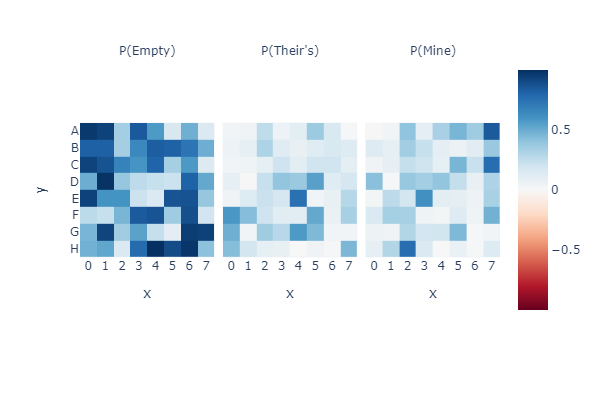

##After a single attention layer (block.0.resid_mid)

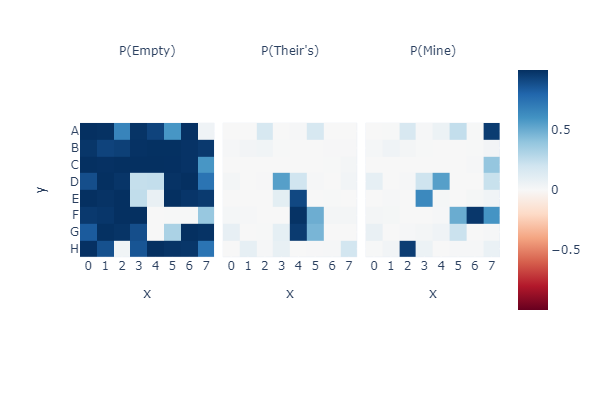

##Probes accuracy on each cell after a single attention pass. y-axis is errors (out of 50 games*59 moves), and x-axis is number of attention heads used. (most effective head first)

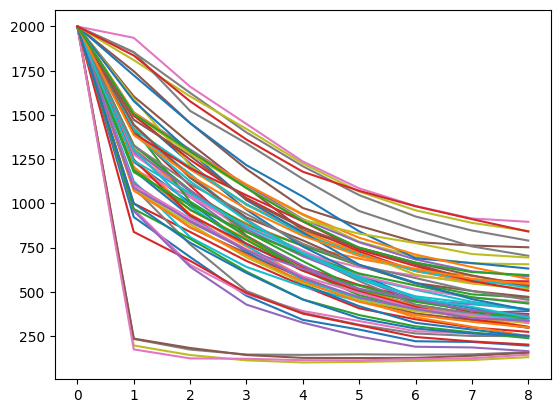

#Directions for future research and mistakes

There's a lot of things I would have liked to do if I had more time, and a few mistakes I made.

Extensions:

1) I didn't end up seeing places that I wanted to use residual stream patching or attention head patching. I bet with more experience/an extra set of eyes, I would have wanted to do these.

2) Cell F4 seems really interesting!

3) I bet there are some really clever things linear algebraic things to do along the lines of decomposing the stream into subspaces which are mostly preserved by most layer operations, and then looking at the places they aren't preserved.

4) When I checked the directions of the probe, there's a spike of a few highly correlated directions. I'm curious what those are about (off the top of my head, could be the blankness of the 4 central cells?)

Mistakes:

1) When measuring the accuracy of blank/not blank predictions, I took error = abs(truth-prediction), and then rounded to 0 if err<.33. I think there are a few better things I could have done here. Most importantly, I think I neglected the fact that the predictions are assymetric--in classifying amongst $n$ classes, a correct yes prediction is automatically correct at above 50%, while a correct no prediction is automatically correct at below $1/n$.

2) I used the resid_mid, and hook_result a fair amount. I noticed that sum(hook_results)+resid_pre did not equal resid_mid, and eventually figured out it was because of b_O. I ended up dividing b_O by 8, and adding that to each of the hook_results, but I think there were probably better things to do.

3) In the image above, I used 2000 as a placeholder number for poor initial accuracy. There's gotta be a more principled thing to do.

4) (Tomb of the unknown mistake) Just here as a reminder to myself that the most dangerous mistakes are the ones I haven't yet realized I made.

#Time and resource usage

I didn't keep careful track of how much time I spend on this. I started out by reading through most of your explainer and glossary, then watching your first video on transformers and then building GPT-2 from scratch. By the time I finished building GPT-2, it's very likely that I was already nearing 10 hours, maybe over. At that point, I looked over your SERIMATS application problem list, and picked the othello network. I went through and reran your code, and did my best to reconstruct your thought process, then started writing my own exploration.

If you only include time from when I started writing my own othello code, it could well be at 10. Overall, it was a very fun project--thanks for all your work making MI welcoming to newcomers :D

There are lots of resources you recommended that I haven't used much yet. The primary two are the TransformerLens tutorial (untouched) and your full set of posts/Kenneth Li's original work on the Othello program (skimmed/underutilized). I'm sure these would have been useful, but I don't know what I would have cut out in favor of those.

#My best guess at our mentor/mentee fit

In your FAQ, you mention 6 things you're looking for in a mentee. My self-assessment of those qualities is here.

Very high: enthusiasm/curiousity, scepticism.
This project is the most fun I've had doing something like this in a long time, and I feel pretty confident that, even amongst people who end up spending enough time to apply for you as a mentor, i'll be above-average in enthusiasm and curiosity. I come from a pure math background, and an upside of that is my ability to tell the difference between conclusive proof and suggestive evidence.

Slightly above/average: empirical truth-seeking, agency and creativity, intuitive reasoning.
I suspect that, amongst the people who are applying to work with you, I'll be roughly average in these things--I'm pretty creative, and have some intuitions about LLMs, but I suspect the same is true of most applicants.

Below average: practicality.
I think the downside of my background is I suspect I have less programming experience than your other applicants--a year ago, I'd done practically no programming in my life. While I'm happy-in-theory to write an interesting piece of code, I think I'm still at the point where it just takes me longer than many people. This is improving (and I think would probably improve pretty rapidly with you as a mentor), but it is a current flaw.

#Direct Neel Nanda copy

In [ ]:
#NN code
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEVELOPMENT_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install transformer_lens==1.2.1
    %pip install git+https://github.com/neelnanda-io/neel-plotly

    # PySvelte is an unmaintained visualization library, use it as a backup if circuitsvis isn't working
    # # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

In [ ]:
#NN code
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: colab


In [ ]:
#NN code
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [ ]:
#NN Code
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

In [ ]:
#NN code
torch.set_grad_enabled(False)

In [ ]:
#NN code
from neel_plotly import line, scatter, imshow, histogram

In [ ]:
#NN code
import transformer_lens.utils as utils
cfg = HookedTransformerConfig(
    n_layers = 8,
    d_model = 512,
    d_head = 64,
    n_heads = 8,
    d_mlp = 2048,
    d_vocab = 61,
    n_ctx = 59,
    act_fn="gelu",
    normalization_type="LNPre"
)
model = HookedTransformer(cfg)

In [ ]:
#NN code
sd = utils.download_file_from_hf("NeelNanda/Othello-GPT-Transformer-Lens", "synthetic_model.pth")
# champion_ship_sd = utils.download_file_from_hf("NeelNanda/Othello-GPT-Transformer-Lens", "championship_model.pth")
model.load_state_dict(sd)

<All keys matched successfully>

In [ ]:
#NN code
if IN_COLAB:
    !git clone https://github.com/likenneth/othello_world
    OTHELLO_ROOT = Path("/content/othello_world/")
    import sys
    sys.path.append(str(OTHELLO_ROOT/"mechanistic_interpretability"))
    from mech_interp_othello_utils import plot_single_board, to_string, to_int, int_to_label, string_to_label, OthelloBoardState
else:
    OTHELLO_ROOT = Path("/workspace/othello_world/")
    from tl_othello_utils import plot_single_board, to_string, to_int, int_to_label, string_to_label, OthelloBoardState

Cloning into 'othello_world'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 70 (delta 15), reused 10 (delta 10), pack-reused 43
Unpacking objects: 100% (70/70), 10.01 MiB | 3.15 MiB/s, done.


In [ ]:
#NN code
board_seqs_int = torch.tensor(np.load(OTHELLO_ROOT/"board_seqs_int_small.npy"), dtype=torch.long)
board_seqs_string = torch.tensor(np.load(OTHELLO_ROOT/"board_seqs_string_small.npy"), dtype=torch.long)

num_games, length_of_game = board_seqs_int.shape
print("Number of games:", num_games,)
print("Length of game:", length_of_game)

Number of games: 100000
Length of game: 60


In [ ]:
#NN code
stoi_indices = [
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
]
alpha = "ABCDEFGH"


def to_board_label(i):
    return f"{alpha[i//8]}{i%8}"


board_labels = list(map(to_board_label, stoi_indices))

#Getting oriented

In [ ]:
#@title Grab game
#@markdown grab game 55, look at first 40 moves
moves_int = board_seqs_int[55, :40]

#apply model to it. Should recieve logits which represent scores of various squares being legal for a 41st move.
logits = model(moves_int)
print("logits:", logits.shape)
logit_vec = logits[0, -1]
#@markdown [0,-1] because batch size 1 (0) and looking at possibilities for next move after final of 40 (-1)
#@markdown now, convert scores to probabilities
log_probs = logit_vec.log_softmax(-1)

#@markdown Remove passing (almost never legal move)
log_probs = log_probs[1:]
assert len(log_probs)==60 #so far so good?

temp_board_state = torch.zeros(64, device=logit_vec.device)
#@markdown  Set all cells to -15 by default, for a very negative log prob - this means the middle cells don't show up as mattering
temp_board_state -= 15.
temp_board_state[stoi_indices] = log_probs

def plot_square_as_board(state, diverging_scale=True, **kwargs):
    """Takes a square input (8 by 8) and plot it as a board. Can do a stack of boards via facet_col=0"""
    if diverging_scale:
        imshow(state, y=[i for i in alpha], x=[str(i) for i in range(8)], color_continuous_scale="RdBu", color_continuous_midpoint=0., aspect="equal", **kwargs)
    else:
        imshow(state, y=[i for i in alpha], x=[str(i) for i in range(8)], color_continuous_scale="Blues", color_continuous_midpoint=None, aspect="equal", **kwargs)
plot_square_as_board(temp_board_state.reshape(8, 8), zmax=0, diverging_scale=True, title="Example Log Probs")

logits: torch.Size([1, 40, 61])


In [ ]:
#@title Sanity check
#@markdown Did we find the right moves? We did!
plot_single_board(int_to_label(moves_int))

#@markdown plotting equivalent board
board = OthelloBoardState()
board.update(to_string(moves_int))
plot_square_as_board(board.state, title="Example Board State (+1 is Black, -1 is White)")

#@markdown and as a list
print("Valid moves:", string_to_label(board.get_valid_moves()))

Valid moves: ['A3', 'A4', 'B4', 'B5', 'B6', 'B7', 'C0', 'F0', 'G5', 'H0', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6']


In [ ]:
#@title grab a tractable list of games, one-hot encode them
num_games = 50
focus_games_int = board_seqs_int[1000:1000+num_games]
focus_games_string = board_seqs_string[1000:1000+num_games]

def one_hot(list_of_ints, num_classes=64):
    out = torch.zeros((num_classes,), dtype=torch.float32)
    out[list_of_ints] = 1.
    return out
#@markdown for each game, at each timestep, at each board position, what is the state?
focus_states = np.zeros((num_games, 60, 8, 8), dtype=np.float32)
#@markdown for each game, at each timestep, which moves are valid?
focus_valid_moves = torch.zeros((num_games, 60, 64), dtype=torch.float32)
for i in (range(num_games)):
    board = OthelloBoardState()
    for j in range(60):
        board.umpire(focus_games_string[i, j].item())
        focus_states[i, j] = board.state
        focus_valid_moves[i, j] = one_hot(board.get_valid_moves())
print("focus states:", focus_states.shape)
print("focus_valid_moves", focus_valid_moves.shape)
model.cfg.use_attn_result = True
focus_logits, focus_cache = model.run_with_cache(focus_games_int[:, :-1])

focus states: (50, 60, 8, 8)
focus_valid_moves torch.Size([50, 60, 64])


In [ ]:
#@title Load the probe
full_linear_probe = torch.load(OTHELLO_ROOT/"main_linear_probe.pth", map_location=torch.device('cpu'))
print(full_linear_probe.shape)
#@markdown the shape is 3, model_dimension, rows, columns, 3
#@markdown The first 3 is the mode of the probe. 0->black to play (odd moves). 1-> white to play (even moves). 2->all moves
#@markdown the final 3 is 0->empty, 1->white, 2->black
#@markdown IF I understand this correctly (BIG IF), I should think of this as a family of 3 functions
#@markdown     (the black probe, the white probe, and one that doesn't work)
#@markdown each function takes in the residual stream (model_dim) and spits out an 8x8 grid with associated scores, via dot-product
#@markdown To the extent this works, it shows the board state is encoded linearly in the residual stream
#@markdown Q: what layer(s) was this trained on??
#@markdown It isn't a priori obvious to me that the model will encode the board in the same dimensions of the residual stream at every layer

torch.Size([3, 512, 8, 8, 3])


In [ ]:
#print(full_linear_probe[0,:,0,0,0]) Yep, that looks like a list of numbers.
print(torch.std_mean(full_linear_probe[0,:,0,0,0]))
#@title apparently its a list of numbers with std .32 and mean -.0045. That looks close to 0 mean, which I think is unsuprising?

(tensor(0.3191, grad_fn=<StdMeanBackward0>), tensor(-0.0045, grad_fn=<StdMeanBackward0>))


In [ ]:
#@title Convert to single function
#@markdown We go ahead and convert this to a single function, by averaging the two functions that work, and thinking of the new final spot
#@markdown      as 0 -> blank, 1 -> (color just played), 2 -> (color to be played) (I may have those last 2 backwards)
rows = 8
cols = 8
options = 3
black_to_play_index = 0
white_to_play_index = 1
blank_index = 0
their_index = 1
my_index = 2
linear_probe = torch.zeros(cfg.d_model, rows, cols, options)
linear_probe[..., blank_index] = 0.5 * (full_linear_probe[black_to_play_index, ..., 0] + full_linear_probe[white_to_play_index, ..., 0])
linear_probe[..., their_index] = 0.5 * (full_linear_probe[black_to_play_index, ..., 1] + full_linear_probe[white_to_play_index, ..., 2])
linear_probe[..., my_index] = 0.5 * (full_linear_probe[black_to_play_index, ..., 2] + full_linear_probe[white_to_play_index, ..., 1])
def get_probe_outputs(layer, game_index, move, **kwargs):
    residual_stream = focus_cache["resid_post", layer][game_index, move]
    #print("residual_stream", residual_stream.shape)
    probe_out = einops.einsum(residual_stream, linear_probe, "d_model, d_model row col options -> row col options")
    return probe_out.softmax(dim=-1)
    #
def contrast_probe_outputs(layer, game_index, move, **kwargs):
    probabilities = get_probe_outputs(layer, game_index, move, **kwargs)
    plot_square_as_board(probabilities, facet_col=2, facet_labels=["P(Empty)", "P(Their's)", "P(Mine)"], height=400, width=600, **kwargs)
    plot_single_board(int_to_label(focus_games_int[game_index, :move+1]))

In [ ]:
#@title Now we look at a move from a game from our focus set.
layer = 6
game_index = 3
move = 10 #after move 0, 5 stones on the board
contrast_probe_outputs(layer, game_index, move)
#@markdown it looks like we understand it (at layer 6, anyway)

In [ ]:
#@title Per layer representations
layer = 6
game_index = 1
move = 10
for i in range(8):
    layer = i
    probabilities = get_probe_outputs(layer, game_index, move)
    plot_square_as_board(probabilities, facet_col=2, facet_labels=["P(Empty)", "P(Their's)", "P(Mine)"], height=400, width=600)
#@markdown It looks like we develop an understanding of the board which is terrible after layer 0 and still bad after layers 1,2,3.
#@markdown      After 4,5,6, things look great. Then, right before we make outputs (after layer 7), we're no longer just trying to represent the board, so the probe goes crazy.

#Starting to investigate

In [ ]:
#@title Let's examine the probe
#@markdown Uncomment print statements to see results.

#@markdown linear_probe = d_model x rows x cols x [blank, just_played, to_play]
sq_linear_probe=torch.square(linear_probe)
magnitudes = torch.sqrt(einops.reduce(sq_linear_probe, "d_model r c o -> r c o", "sum"))
norm_linear_probe = linear_probe/magnitudes
#print(magnitudes[:, :, 1])
#@markdown It seems reasonable to hope that, for any given cell, (blank) and (just_played) will be related (and thus have non-zero dot product)
#@markdown and similarly with (blank) and (to_play)
blank_dot_last = torch.round(10*einsum("d r c, d r c -> r c", norm_linear_probe[:,:,:,0], norm_linear_probe[:,:,:,1]))
blank_dot_next = torch.round(10*einsum("d r c, d r c -> r c", norm_linear_probe[:,:,:,0], norm_linear_probe[:,:,:,2]))
#print(blank_dot_last, blank_dot_next)
#@markdown yep, looks like significant negative correlation for most cells. The exceptions are the central 4 cells, which makes sense--they're never blank!
#@markdown The sum of the two non-blanks should be the opposite direction of the blank
notblank = einops.reduce(linear_probe[:,:,:,1:], "d r c o -> d r c", "sum")
notblank_mag = torch.sqrt(einops.reduce(torch.square(notblank), "d_model r c -> r c", "sum"))
norm_notblank = notblank/notblank_mag
blank_dot_sum_notblank = torch.round(10*einsum("d r c, d r c -> r c", norm_linear_probe[:,:,:,0], norm_notblank))
#print(blank_dot_sum_notblank)
#@markdown yep, we are getting lots of -9 and -10, which means almost exactly opposite direction. again, the 4 central cells are excepted.
#@markdown This gives some evidence of Neel Nanda's claim that
#@markdown    "blank - (mine + their's)/2 [gives] a 'is this cell empty or not' direction"

#@markdown I'm not sure why this should give something better than just the "blank" direction though?

torch.Size([192])


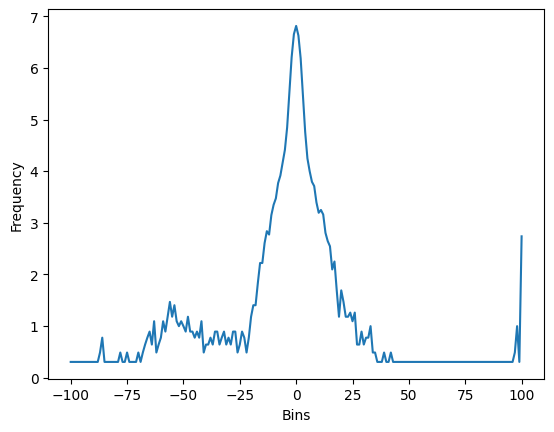

In [ ]:
#@title Let's check the entire probe for correlations
import matplotlib.pyplot as plt
linear_probe.shape
reshaped_probe = einops.rearrange(linear_probe, "model_dim r c m ->model_dim (r c m) ")
reshaped_probe.shape
norms = torch.linalg.vector_norm(reshaped_probe, dim=0)
print(norms.shape)
all_dots = einsum("r c1, r c2 -> c1 c2", reshaped_probe, reshaped_probe)
normed_dots = all_dots/einsum("() c1, () c2 -> c1 c2", norms, norms)

hist = torch.histc(100*normed_dots, bins = 201, min = -100, max = 100)
x = range(-100, 101)
#plt.plot(x[:], hist)
#@markdown Almost every vector in the probe has 0 correlation with almost every other vector.

#Taking a log to get more detail:
plt.plot(x[:], torch.log(10+hist)-2)
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.show()

#@markdown It looks like most vectors in the probe are close to uncorrelated, which makes sense. Many more have some negative correlation
#@markdown    (a given cells blankness, last_played_color, and next_played_color should all have negative correlation). There's a spike at
#@markdown    full correlation, which is each vector being correlated with itself. The smaller spike right next to that might be interesting, though!

In [ ]:
#@title Getting activations and weights
#@markdown We will want both activations and weights of the model. Let's make sure we understand how to get those.

#for key, value in focus_cache.items():
#    print(key, value.shape)
print(focus_cache)
for i in model.named_parameters():
    if ".0." in i[0] or "blocks" not in i[0]:
        print(i[0], i[1].shape)
#@markdown It looks like the parameters don't show any learned weights for the LayerNorms?
#@markdown so focus_cache is a dictionary with the below objects. Let's make sure we understand some of the relationships
#@markdown The positional embeddings shouldn't depend on which game we look at
a = torch.equal(focus_cache["hook_pos_embed"][4,:,:], focus_cache["hook_pos_embed"][27,:,:])
#@markdown the initial inputs should be the sums of the embeddings
b = torch.equal(focus_cache["hook_embed"]+focus_cache["hook_pos_embed"], focus_cache["blocks.0.hook_resid_pre"])
print(a,b) #True, true. Very true.

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.attn.hook_result', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.attn.hook_result', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.ho

#Examining a single cell

In [ ]:
#@title  lets consider cell (6,6), also known as cell 50 (of 0-59) or 51 (of 1-60)
#@markdown we grab the linear probe that tests its blankness
is_66_blank_probe = linear_probe[:,6,6,0]
torch.histogram(10*is_66_blank_probe, bins = 20)
#@markdown most of the values cluster around 0, suggesting something sparse-ish. Good!

torch.return_types.histogram(
hist=tensor([ 1.,  4.,  2.,  5.,  4., 17., 21., 33., 55., 76., 76., 61., 57., 43.,
        34., 16.,  4.,  2.,  0.,  1.], grad_fn=<NotImplemented>),
bin_edges=tensor([-14.4601, -13.0813, -11.7024, -10.3236,  -8.9448,  -7.5659,  -6.1871,
         -4.8083,  -3.4294,  -2.0506,  -0.6718,   0.7071,   2.0859,   3.4647,
          4.8436,   6.2224,   7.6012,   8.9801,  10.3589,  11.7377,  13.1166],
       grad_fn=<NotImplemented>))

In [ ]:
#@title The question "is this cell occupied" sure seems like it should correlate with the embedding and unembedding
#We'll use 51 for the cell identifier because we haven't removed the "pass" move.
embed_66 = model.embed.W_E[51,:]
unembed_66 = model.unembed.W_U[:,51]
is_66_blank_probe = linear_probe[:,6,6,0]
#print(unembed_66.shape, is_66_blank_probe.shape)
a = torch.nn.functional.cosine_similarity(embed_66, is_66_blank_probe, dim = 0)
b = torch.nn.functional.cosine_similarity(unembed_66, is_66_blank_probe, dim = 0)
#c = torch.nn.functional.cosine_similarity(unembed_66, embed_66, dim = 0) This was a pretty small number--not sure what that means.
print(a,b)

#.43 suggests a somewhat similar direction, but a long way from parallel. How does that compare with the other squares?
for i in range(45, 55):
    unembed_vec = model.unembed.W_U[:,i]
    print(i, torch.nn.functional.cosine_similarity(unembed_vec, is_66_blank_probe, dim = 0))
#clearly, MUCH more closely related! good, it would be weird otherwise

for i in range(45, 55):
    embed_vec = model.embed.W_E[i,:]
    print(i, torch.nn.functional.cosine_similarity(embed_vec, is_66_blank_probe, dim = 0))
#The embed vector looks a little less extreme, but still clearly more correlated than the surroundings.
#The signs are opposite, which is to be expected. When we embed the move, that suggests not-blank. When we play the move, that suggests blank.


tensor(-0.1736, grad_fn=<SumBackward1>) tensor(0.4314, grad_fn=<SumBackward1>)
45 tensor(-0.0059, grad_fn=<SumBackward1>)
46 tensor(-0.0101, grad_fn=<SumBackward1>)
47 tensor(0.0023, grad_fn=<SumBackward1>)
48 tensor(0.0022, grad_fn=<SumBackward1>)
49 tensor(0.0207, grad_fn=<SumBackward1>)
50 tensor(0.0256, grad_fn=<SumBackward1>)
51 tensor(0.4314, grad_fn=<SumBackward1>)
52 tensor(-0.0447, grad_fn=<SumBackward1>)
53 tensor(-0.0164, grad_fn=<SumBackward1>)
54 tensor(-0.0060, grad_fn=<SumBackward1>)
45 tensor(0.0523, grad_fn=<SumBackward1>)
46 tensor(0.0455, grad_fn=<SumBackward1>)
47 tensor(0.0265, grad_fn=<SumBackward1>)
48 tensor(0.0352, grad_fn=<SumBackward1>)
49 tensor(0.0166, grad_fn=<SumBackward1>)
50 tensor(-0.0570, grad_fn=<SumBackward1>)
51 tensor(-0.1736, grad_fn=<SumBackward1>)
52 tensor(0.0224, grad_fn=<SumBackward1>)
53 tensor(-0.0123, grad_fn=<SumBackward1>)
54 tensor(0.0354, grad_fn=<SumBackward1>)


In [ ]:
#@title let's look severely out of distribution. As long as we play cell 51, can the model tell it isn't blank, even if the rest of the moves are invalid?
all_51s = torch.diag(51*torch.ones(58, dtype = torch.long),diagonal = -1)
print(all_51s)
mono_logits, mono_cache = model.run_with_cache(all_51s)

#@markdown which cursed game do we look at?
gamecheck = 10

logit_vec = mono_logits[gamecheck, gamecheck,:]
#@markdown now, convert scores to probabilities
log_probs = logit_vec.log_softmax(-1)

#@markdown  Remove passing (almost never legal move)
log_probs = log_probs[1:]
assert len(log_probs)==60 #@markdown so far so good?

temp_board_state = torch.zeros(64, device=logit_vec.device)
#@markdown  Set all cells to -15 by default, for a very negative log prob - this means the middle cells don't show up as mattering
temp_board_state -= 15.
temp_board_state[stoi_indices] = log_probs

plot_square_as_board(temp_board_state.reshape(8, 8), zmax=0, diverging_scale=False, title="Example Log Probs")

#@markdown It seems like this doesn't work at all. I was imagining "passing" as neutral, but I think the model believes (correctly!)
#@markdown       that passing indicates a severely restricted boardstate, so most moves are probably illegal.
#@markdown It generally seems to not have anything special about cell 51 = (6,6) = g6, unless im grossly wrong about something.
#@markdown like, its blank-ish, but so are many other cells.


tensor([[ 0,  0,  0,  ...,  0,  0,  0],
        [51,  0,  0,  ...,  0,  0,  0],
        [ 0, 51,  0,  ...,  0,  0,  0],
        ...,
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ..., 51,  0,  0],
        [ 0,  0,  0,  ...,  0, 51,  0]])


In [ ]:
#@title Lets go into distribution, this time with an opening that gets to the square quickly.
short_logits, short_cache = model.run_with_cache(torch.tensor([41,42,43,51]))

#@markdown trying this with 2 or with 3:
logit_vec = short_logits[0, 3 ,:]

log_probs = logit_vec.log_softmax(-1)
log_probs = log_probs[1:]
assert len(log_probs)==60
temp_board_state = torch.zeros(64, device=logit_vec.device)
temp_board_state -= 15.
temp_board_state[stoi_indices] = log_probs

plot_square_as_board(temp_board_state.reshape(8, 8), zmax=0, diverging_scale=False, title="Example Log Probs")
#@markdown okay, so between index 2 and 3, the model correctly changes from (6,6) being playable to being occupied.

In [ ]:
#@title Obvious thing to try: see what happens to the embed vector for token 51.
embedded_token = model.embed.W_E[51, :]
#@markdown we would normally add a positional embedding vector to it. Does this interact?
#@markdown for i in range(59):
#@markdown     pos_embed_vec = model.pos_embed.W_pos[i,:]
#@markdown     print(i,torch.round(100*torch.nn.functional.cosine_similarity(pos_embed_vec, embedded_token, dim = 0)))
#@markdown it looks like the cosine similarity is under .1 for all possible positions, so we aren't interacting much. Good!

#@markdown I'd hope that the answer to "Given that 6,6 was just played, how much attention should we pay to the xth move of the game?"
#@markdown    would be pretty low. On the other hand, the question "If a head is looking for when 6,6 was played, it was here!" should be high.
#@markdown    Thus, I anticipate W_Q being small for all 8 heads, and W_K being high for at least one head.
Q_weights = model.blocks[0].attn.W_Q
Q_vecs = einsum("heads d_model h_dim, d_model -> heads h_dim", Q_weights, embedded_token)
print("Q norms: ",torch.linalg.vector_norm(Q_vecs+model.blocks[0].attn.b_Q, dim=1))

K_weights = model.blocks[0].attn.W_K
K_vecs = einsum("heads d_model h_dim, d_model -> heads h_dim", K_weights, embedded_token)
print("K norms: ",torch.linalg.vector_norm(K_vecs+model.blocks[0].attn.b_K, dim=1))

V_weights = model.blocks[0].attn.W_V
V_vecs = einsum("heads d_model h_dim, d_model -> heads h_dim", V_weights, embedded_token)
print("V norms: ",torch.linalg.vector_norm(V_vecs+model.blocks[0].attn.b_V, dim=1))

#@markdown Well, I was very wrong.

Q norms:  tensor([1.9552, 3.1259, 3.8038, 2.8002, 3.9612, 4.1889, 2.7038, 3.3021],
       grad_fn=<LinalgVectorNormBackward0>)
K norms:  tensor([3.7769, 1.2165, 3.6754, 3.6053, 1.0492, 0.9768, 2.6344, 2.2578],
       grad_fn=<LinalgVectorNormBackward0>)
V norms:  tensor([0.6905, 1.1243, 0.6386, 0.7951, 1.1136, 1.0767, 0.8428, 0.7547],
       grad_fn=<LinalgVectorNormBackward0>)


In [ ]:
model.cfg.use_attn_result = True
short_logits, short_cache = model.run_with_cache(torch.tensor([[41,42,43,49],[41,42,43,51]]))
is_66_blank_probe = linear_probe[:,6,6,0]
is_64_blank_probe = linear_probe[:,6,4,0]
#for key, value in short_cache.items():
#    print(key, value.shape)
for i in range(8):
    actives = short_cache["blocks."+str(i)+".hook_resid_pre"]
    print(actives.shape)
    active_no_66 = actives[0,3,:]
    active_yes_66 = actives[1,3,:]
    diff = active_yes_66 - active_no_66
    cos_sim = torch.round(100*torch.nn.functional.cosine_similarity(active_no_66, active_yes_66, dim = 0))
    print("after layer ", i, "cos similarity of ", cos_sim)
    print("diff of ", torch.norm(diff), " with dot ", torch.dot(is_66_blank_probe, diff))
#@title This seems like it should be instructive, but I don't see anything interesting here.

torch.Size([2, 4, 512])
after layer  0 cos similarity of  tensor(52.)
diff of  tensor(4.1729)  with dot  tensor(-5.0460, grad_fn=<DotBackward0>)
torch.Size([2, 4, 512])
after layer  1 cos similarity of  tensor(55.)
diff of  tensor(7.6725)  with dot  tensor(-15.7606, grad_fn=<DotBackward0>)
torch.Size([2, 4, 512])
after layer  2 cos similarity of  tensor(68.)
diff of  tensor(9.0547)  with dot  tensor(-16.2463, grad_fn=<DotBackward0>)
torch.Size([2, 4, 512])
after layer  3 cos similarity of  tensor(76.)
diff of  tensor(9.6563)  with dot  tensor(-19.0321, grad_fn=<DotBackward0>)
torch.Size([2, 4, 512])
after layer  4 cos similarity of  tensor(80.)
diff of  tensor(10.4740)  with dot  tensor(-24.0198, grad_fn=<DotBackward0>)
torch.Size([2, 4, 512])
after layer  5 cos similarity of  tensor(82.)
diff of  tensor(12.0212)  with dot  tensor(-28.3955, grad_fn=<DotBackward0>)
torch.Size([2, 4, 512])
after layer  6 cos similarity of  tensor(77.)
diff of  tensor(16.6284)  with dot  tensor(-29.3592, 

In [ ]:
actives = short_cache["blocks.6.hook_resid_pre"]
probed_boardstates = einsum("d r c o, b m d -> b m r c o", linear_probe, actives)
probed_boardstates = probed_boardstates[:,3,:,:,:]
probabilities = probed_boardstates[0].softmax(dim=-1)
plot_square_as_board(probabilities, facet_col=2, facet_labels=["P(Empty)", "P(Their's)", "P(Mine)"], height=400, width=600)
#@title the model definitely knows blankness by layer 6. What does it know earlier?

In [ ]:
#@title Running both of these:

#actives = short_cache["blocks.0.hook_resid_pre"]
actives = short_cache["blocks.1.hook_resid_pre"]
probed_boardstates = einsum("d r c o, b m d -> b m r c o", linear_probe, actives)
probed_boardstates = probed_boardstates[:,3,:,:,:]
probabilities = probed_boardstates[0].softmax(dim=-1)
plot_square_as_board(probabilities, facet_col=2, facet_labels=["P(Empty)", "P(Their's)", "P(Mine)"], height=400, width=600)
probabilities = probed_boardstates[1].softmax(dim=-1)
plot_square_as_board(probabilities, facet_col=2, facet_labels=["P(Empty)", "P(Their's)", "P(Mine)"], height=400, width=600)
#@markdown After just the first layer (blocks.0 to blocks.1), the model has gone from "go home, model, you're drunk" to basically correct about what is blank

#@markdown Lets see if we can find exactly where that happens


In [ ]:
actives = short_cache["blocks.0.hook_resid_mid"]
probed_boardstates = einsum("d r c o, b m d -> b m r c o", linear_probe, actives)
probed_boardstates = probed_boardstates[:,3,:,:,:]
probabilities = probed_boardstates[0].softmax(dim=-1)
plot_square_as_board(probabilities, facet_col=2, facet_labels=["P(Empty)", "P(Their's)", "P(Mine)"], height=400, width=600)
probabilities = probed_boardstates[1].softmax(dim=-1)
plot_square_as_board(probabilities, facet_col=2, facet_labels=["P(Empty)", "P(Their's)", "P(Mine)"], height=400, width=600)
#@title okay, so it looks like the model has a pretty good idea of whether 64 or 66 has been played after *only the first attention layer*--no MLP needed!
#@markdown   (Although in the case that 64 is played, it seems very uncertain about 65??)

In [ ]:
#@title What are the heads paying attention to?
short_cache["blocks.0.attn.hook_pattern"].shape
#for i in range(2):
#    for j in range(8):
#        print(torch.round(10*short_cache["blocks.0.attn.hook_pattern"][i,j,3]))
#@markdown The patterns looks similar between the 2 games. Heads 4 and 5 seem most focused on the current move--maybe they  are responsible for recording blankness?
probe_for_blanks = linear_probe[:,:,:,:] #recall [model_dim, r, c, options]
head_outs = short_cache["blocks.0.attn.hook_result"][:, 3, 4:6, :] #[game_id, move#, head_id, model_dim]

probed_outs = einsum("model_dim r c o, game_id head model_dim -> game_id head r c o", probe_for_blanks, head_outs)
probabilities = probed_outs[1,1].softmax(dim=-1)
plot_square_as_board(probabilities, facet_col=2, facet_labels=["P(Empty)", "P(Their's)", "P(Mine)"], height=400, width=600)
#@markdown Head 4 seems not super-helpful, but head 5 seems promising.

#Examining all cells

In [ ]:
#@title This was very ad-hoc and small sample-sized.

#@markdown My background is pure math, not stat, but even I'm uncomfortable
#@markdown     drawing conclusions from sample size 2. Let's do something more systematic.

#@markdown Based on previous work above, we conjecture:
#@markdown CONJECTURE 1
#@markdown    the model knows the non-blankness of the most-recently played cell after the first (0th) attention layer,
#@markdown    and know it in a way extractable by the linear probe. Testing that:

probed_after_attn0 = einsum("game_id move model_dim, model_dim r c o -> game_id move r c o", focus_cache["blocks.0.hook_resid_mid"], linear_probe)
game_id = 42
move_num = 37
probabilities = probed_after_attn0[game_id,move_num].softmax(dim=-1)
plot_square_as_board(probabilities, facet_col=2, facet_labels=["P(Empty)", "P(Their's)", "P(Mine)"], height=400, width=600)
plot_single_board(int_to_label(focus_games_int[game_id, :move_num+1]))
blank_truth = 1-torch.abs(torch.tensor(focus_states[:,:-1]))
errors = torch.abs(blank_truth-(probed_after_attn0.softmax(dim=-1)[...,0]))
rounded_errors = torch.nn.functional.threshold(errors, .33, 0)
square_errors = einops.reduce(rounded_errors,"game move r c-> r c", "sum")
square_errors_mag = einops.reduce(rounded_errors,"game move r c-> r c", "mean")
count_errors = torch.count_nonzero(rounded_errors, dim = [0,1])

In [ ]:
#plot_square_as_board(square_errors, height=400, width=600)
print(count_errors.shape)
plot_square_as_board(count_errors/(50*59), height=400, width=600, zmax = 1, zmin = -1)

#@title It looks like the total accuracy is pretty high, except for the corners. Conjecture 1' confirmed!!
#@markdown CONJECTURE 1': the model knows, not just non-blankness of most recently played cell
#@markdown    but also the blankness-status of almost every cell.

#@markdown    We still haven't actually confirmed conjecture 1, but it should be easy at this point

torch.Size([8, 8])


In [ ]:
current_move_errors = torch.zeros_like(errors)
def move_int_to_boardpos(i):

    x=stoi_indices[i-1] #we aren't passing
    return x//8, x%8
for x in range(50):
    for y in range(59):
        movea, moveb = move_int_to_boardpos(focus_games_int[x,y])
        current_move_errors[x,y,movea, moveb]+=1
current_move_errors = current_move_errors*rounded_errors
current_move_errors = current_move_errors[:, :, :,:]
count_current_errors = torch.count_nonzero(current_move_errors, dim = [0,1])

In [ ]:
plot_square_as_board(count_current_errors, height=400, width=600, zmax = 50)
#@title We've confirmed conjecture 1...except for cell F4??

In [ ]:
imshow(current_move_errors[:,:,5,4])
focus_games_int[torch.argwhere(current_move_errors[:,0,5,4]>.2),0]
#@title It looks like our probe is not successful at extracting the non-blankness of F4 from our model when F4 is the first cell played.
#@markdown This could be because the model is storing the information for F4 elsewhere at this point, or the model will use a different head
#@markdown    or an MLP layer to tell

tensor([[41],
        [41],
        [41],
        [41],
        [41],
        [41],
        [41],
        [41],
        [41],
        [41],
        [41],
        [41],
        [41],
        [41]])

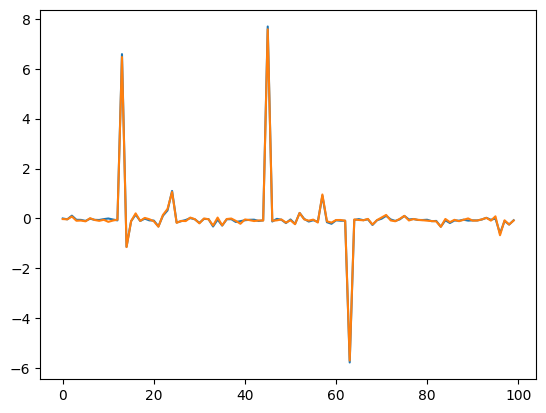

In [ ]:
#@title CONJECTURE 2: We can identify which attention head(s) the model does this with! Let's start by making sure we understand the tools
#@markdown probed_after_attn0 = einsum("game_id move model_dim, model_dim r c o -> game_id move r c o", focus_cache["blocks.0.hook_resid_mid"], linear_probe)

attn_sum = einops.reduce(focus_cache["blocks.0.attn.hook_result"], "a b c d -> a b d", "sum")
diff = focus_cache["blocks.0.hook_resid_mid"] - attn_sum

N=100
plt.plot(focus_cache["blocks.0.hook_resid_pre"][0,0,:N])
plt.plot(diff[0,0,:N])
#@markdown okay, they aren't literally "the same", but they do look close





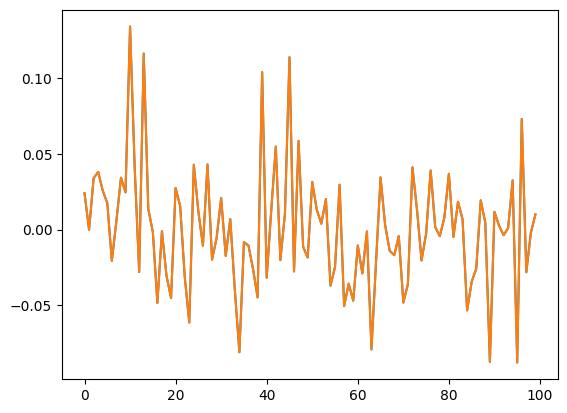

In [ ]:
plt.plot((focus_cache["blocks.0.hook_resid_pre"][0,0,:N]-diff[0,0,:N]))
plt.plot(attn_sum[0,0,:N] - focus_cache["blocks.0.hook_attn_out"][0,0,:N])
#@title Weird, possibly floating point error???
#@markdown yeah, because hook_result is not the real thing which gets used, it's slightly off from attn_out

#@markdown The errors seem to be too big to be floating point errors, actually, but too small to be anything serious.

#@markdown I am confused by this--is there a bug in TransfomerLens?

False
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, T

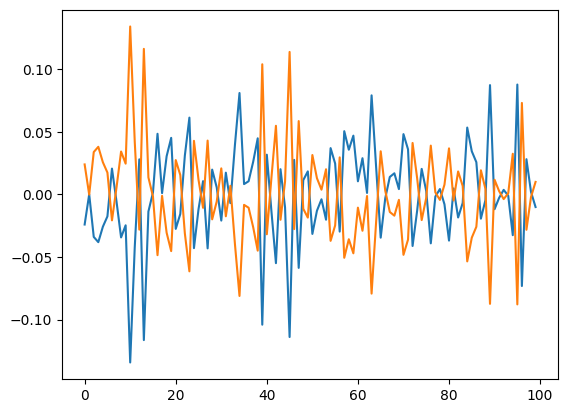

In [ ]:
#@title (an unreasonable amount of time later...)
#@markdown Okay, I went into the transfomerLens source code, and I think I found the issue, which is obvious in retrospect:

#@markdown  blocks.0.attn.b_O has been added when forming attn_out, but there is no principled way to decompose it amongst the 8 heads, so hook_result doesn't include it at all!

#@markdown confirming...
plt.plot(model.blocks[0].attn.b_O.detach().numpy()[:N])
plt.plot((focus_cache["blocks.0.hook_resid_pre"][0,0,:N]-diff[0,0,:N]))
#@markdown Yep, pretty clearly one is the negative of the other

biased_hooks = focus_cache["blocks.0.attn.hook_result"]+(model.blocks[0].attn.b_O/8)
biased_attn_sum = einops.reduce(biased_hooks, "a b c d -> a b d", "sum")
diff = focus_cache["blocks.0.hook_resid_mid"] - biased_attn_sum
print(torch.equal(diff, focus_cache["blocks.0.hook_resid_pre"]))
print(torch.isclose(diff, focus_cache["blocks.0.hook_resid_pre"]))
#@markdown Okay, so lets work with the biased_hooks

In [ ]:
#@title Bookkeeping errors...

hypo_resid_mids = biased_hooks+einops.repeat(focus_cache["blocks.0.hook_resid_pre"], "game move model_dim ->game move heads model_dim", heads = 8)
heads_probed_after_attn0 = einsum("game_id move heads model_dim, model_dim r c o -> game_id move heads r c o", hypo_resid_mids, linear_probe)
blank_truth = 1-torch.abs(torch.tensor(focus_states[:,:-1]))
blank_truth_rep = einops.repeat(blank_truth,"game_id move r c ->game_id move heads r c", heads = 8)

errors = torch.abs(blank_truth_rep-(heads_probed_after_attn0.softmax(dim=-1)[...,0]))
rounded_errors = torch.nn.functional.threshold(errors, .33, 0)
square_errors = einops.reduce(rounded_errors,"game move heads r c-> heads r c", "sum")
square_errors_mag = einops.reduce(rounded_errors,"game move heads r c-> heads r c", "mean")
count_errors = torch.count_nonzero(rounded_errors, dim = [0,1])

In [ ]:
for i in range(8):
    plot_square_as_board(count_errors[i]/(50*59), height=400, width=600, zmax = 1, zmin = -1)
#@title Well, this is a bit disconcerting. Visual inspection doesn't make it look like any head is more or less good at this overall.


In [ ]:
best_case_error_count = einops.reduce(count_errors, "heads r c->r c", "min")
plot_square_as_board(best_case_error_count/(50*59), height=400, width=600, zmax = 1, zmin = -1)
#@title Comparing this with the resid_mid error picture
#@markdown It seems pretty clear that no cell has an individual head that write blankness into the residual stream--all the cells are composite.

#@markdown Can we at least find cell/head pairs where the head does NOT help?

In [ ]:
def subset_to_error_count(x):
    subset_of_biased_hooks = biased_hooks[:,:,x,:]
    subset_hypo_resid_mids = einops.reduce(subset_of_biased_hooks, "game_id move heads model_dim -> game_id move model_dim", "sum")+focus_cache["blocks.0.hook_resid_pre"]
    probed_resid_subset = einsum("game_id move model_dim, model_dim r c o -> game_id move r c o", subset_hypo_resid_mids, linear_probe)
    subset_errors = torch.abs(blank_truth-(probed_resid_subset.softmax(dim=-1)[...,0]))
    subset_rounded_errors = torch.nn.functional.threshold(subset_errors, .33, 0)
    subset_count_errors = torch.count_nonzero(subset_rounded_errors, dim = [0,1])
    return subset_count_errors
for i in range(8):
    diff =subset_to_error_count([i])- count_errors[i]
    plot_square_as_board(diff/(50*59), height=400, width=600, zmax = 1, zmin = -1)
#@title Our function seems to work?

In [ ]:
#@title Lets just check every possible subset of heads

all_subset_errors = torch.empty((256, 8,8))

for i in range(256):
    bin_string = bin(i)[2:]
    binstring = ("0"*(8-len(bin_string)))+bin_string
    subset = [7-j for j in range(8) if int(binstring[j])]
    board = subset_to_error_count(subset)
    all_subset_errors[i] = board

In [ ]:
#Every square which is 255 is improved by every head. Thats almost all the squares :(
torch.argmin(all_subset_errors, dim = 0)


tensor([[123, 127, 255, 255, 255, 255, 235, 251],
        [239, 255, 255, 255, 255, 251, 255, 127],
        [223, 255, 254, 254, 254, 255, 255, 255],
        [255, 255, 254, 162, 224, 190, 255, 255],
        [255, 255, 251, 225, 161, 251, 255, 255],
        [255, 255, 255, 254, 254, 255, 255, 255],
        [253, 255, 127, 255, 254, 255, 255, 255],
        [251, 255, 253, 255, 223, 255, 253, 255]])

In [ ]:
#@title Greedily computing error paths

tiered_subsets = []
for i in range(9):
    subsets = set()
    tiered_subsets.append(subsets)
for i in range(256):
    bin_string = bin(i)[2:]
    binstring = ("0"*(8-len(bin_string)))+bin_string
    subset = [7-j for j in range(8) if int(binstring[j])]
    tiered_subsets[len(subset)].add(frozenset(subset))

def set_to_num(x):
    val = 0
    for power in x:
        val+=2**power
    return int(val)

paths = []

for i in range(8):
    li = []
    for j in range(8):
        lj = [ set()]
        for k in range(1,8):
            min = 10000
            best_head = 10
            for head in set([0,1,2,3,4,5,6,7])-lj[-1]:
                #print("checking ", head, " in ", set([0,1,2,3,4,5,6,7])-lj[-1])

                if all_subset_errors[set_to_num(set.union(lj[-1],set([head]))),i,j] < min:
                    #print("updating previous best", min, " to ", all_subset_errors[set_to_num(set.union(lj[-1],set([head]))),i,j], "as a result of ", i, j, k, head)
                    min = all_subset_errors[set_to_num(set.union(lj[-1],set([head]))),i,j]
                    best_head = head
            lj.append(set.union(lj[k-1],set([best_head])))

        li.append(lj)
    paths.append(li)

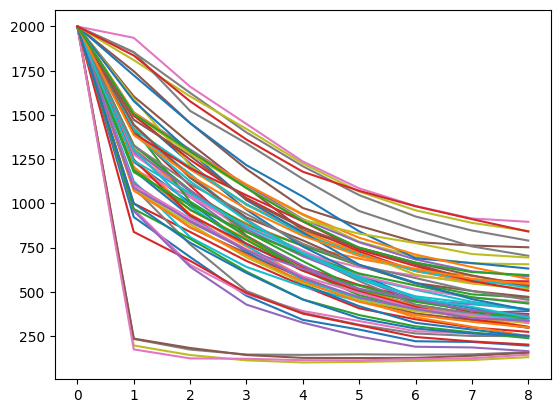

In [ ]:
#@title If we greedily take every error reduction, our error keeps falling as we add more heads. There are
#@markdown    4 cells which have dramatically lower error immediately. Probably those are the 4 center cells which are never blank.
all_cells = torch.empty((64, 8))
for i in range(64):
    errors = [2000]
    x,y = i//8, i%8
    for j in range(8):
        err = errors[-1]
        if set_to_num(paths[x][y][j])<256:
            err = all_subset_errors[set_to_num(paths[x][y][j])][x][y]
        errors.append(err)
        all_cells[i,j]=err
    plt.plot(errors)

In [ ]:
print(torch.argmin(all_cells, dim = 0))
print(all_cells[35], all_cells[27])
a,b = torch.sort(all_cells[:,0])
print(a, b)
#@title Yep, the 4 lowest errors are the 4 central cells.

tensor([36, 36, 28, 28, 28, 28, 28, 28])
tensor([236., 183., 143., 127., 126., 127., 139., 156.]) tensor([234., 174., 146., 144., 147., 145., 147., 159.])
tensor([ 175.,  197.,  234.,  236.,  839.,  923.,  957.,  968.,  969., 1000.,
        1000., 1072., 1081., 1088., 1089., 1089., 1102., 1112., 1125., 1177.,
        1186., 1189., 1192., 1207., 1235., 1241., 1246., 1248., 1277., 1286.,
        1300., 1305., 1310., 1327., 1327., 1329., 1387., 1394., 1396., 1403.,
        1404., 1419., 1424., 1425., 1443., 1445., 1473., 1496., 1505., 1505.,
        1506., 1508., 1514., 1515., 1578., 1592., 1605., 1724., 1747., 1810.,
        1836., 1854., 1855., 1936.]) tensor([36, 28, 27, 35, 43, 20, 44, 26, 52, 13, 60, 51, 38, 54, 25, 37, 46, 34,
        19, 42, 30, 32, 16, 21,  0, 59, 11, 33,  6,  4, 24, 29,  1,  2, 47, 12,
        61, 49, 53,  9,  3, 39, 22, 31, 17, 45, 55, 23,  8, 62, 10, 58, 14, 41,
        50, 18,  5, 40, 15, 48, 63,  7, 57, 56])
